In [34]:
%load_ext autoreload
%autoreload 2
from gratin.models.main_net import MainNet
from gratin.data.datamodule import DataModule
import pytorch_lightning as pl
from gratin.training.utils import setup_trainer
from gratin.models.utils import get_predictions_of_dl
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dl_params = {"batch_size":128,"num_workers":0}

In [3]:
graph_info = {"edges_per_point":10,
                "clip_trajs":False,
                "scale_types":["step_sum","pos_std", "step_std"],
                "log_features":True,
                "data_type":"no_features", # no features because features are all computed by the model
                "edge_method":"geom_causal"}

In [4]:
ds_params = {
        "dim":2, # can be (1, 2 or 3)
        "RW_types":["fBM","LW","sBM","OU","CTRW"], # Types of random walks used during training
        "time_delta":0.015, # Time interval between successive positions, in seconds
        #"logdiffusion_range":(1.009,1.01),
        "logdiffusion_range":(-2.,1.1), # log-diffusionis drawn using a truncated gaussian
        "length_range":(7,35), # length is drawn in a log-uniform way
        #"noise_range":(0.,0.),
        "noise_range":(0.015,.06), # localization uncertainty, in micrometers
}

In [5]:
model = MainNet(tasks=["alpha","model"],
    n_c=16,
    latent_dim=16,
    lr=1e-3,
    dim=2,
    RW_types=ds_params["RW_types"],
    scale_types=["step_std","pos_std"])

Global seed set to 1


stage is None, strange...
Create TrajDataset, seed_offset = 0
Create TrajDataset, seed_offset = 100000
Plotting


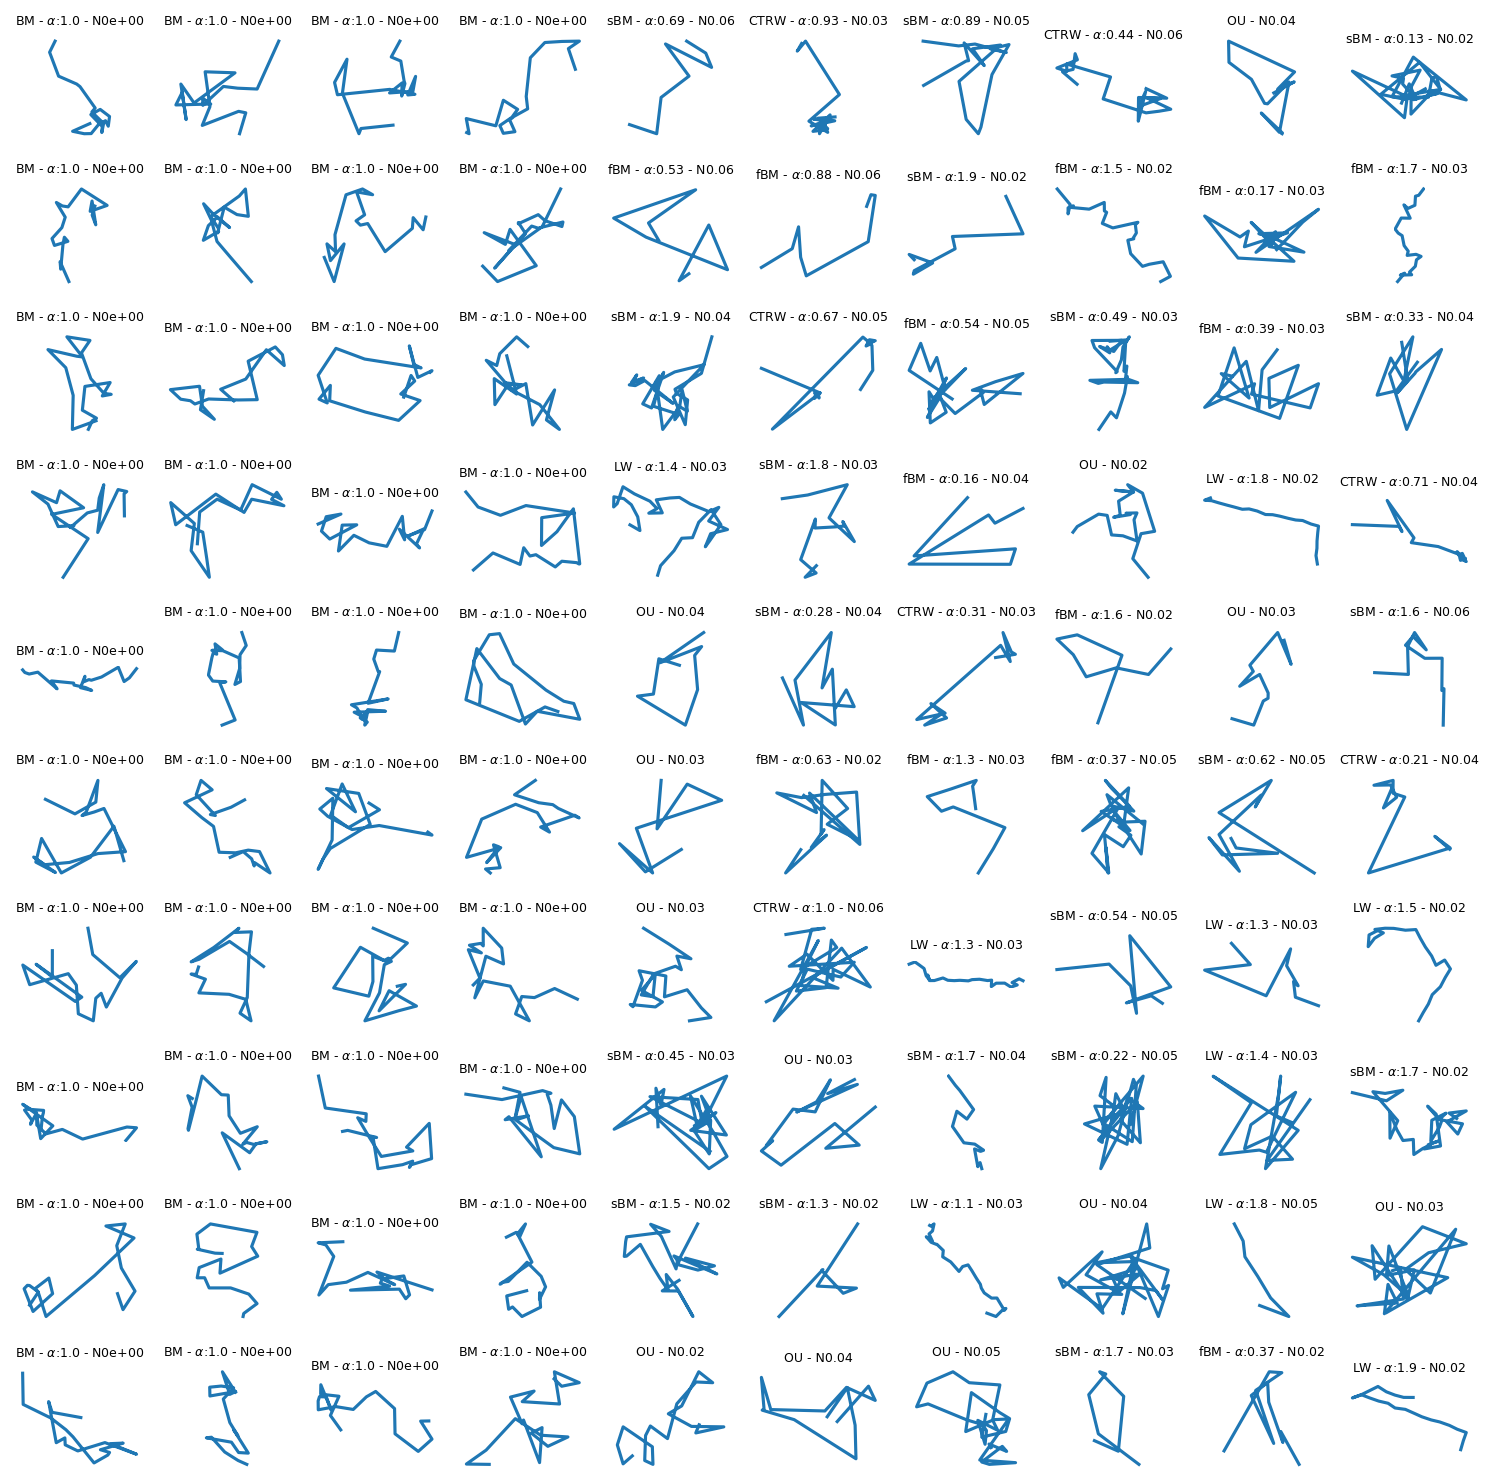

In [6]:
pl.seed_everything(1)
dm = DataModule(ds_params=ds_params, dl_params=dl_params, graph_info=graph_info)
dm.setup(plot=True)

In [7]:
TAG = "demo"
tb_logger = pl.loggers.TensorBoardLogger(save_dir='/Users/hverdier/tb_logs',default_hp_metric=False,name=TAG,flush_secs=60)
trainer = setup_trainer(tb_logger,dirpath="/Users/hverdier/models",tag=TAG)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model,datamodule=dm)

In [8]:
model = MainNet.load_from_checkpoint("/Users/hverdier/models/demo-v3.ckpt")

In [9]:
trainer.test(model, dm.test_dataloader())

Create TrajDataset, seed_offset = 100000


/Users/hverdier/opt/miniconda3/envs/gratin/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     alpha_test_loss        0.5280817151069641
     model_test_loss        0.6499460935592651
         test_F1            0.5276442170143127
        test_MAE            0.33059263229370117
        test_loss            1.072995901107788
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'alpha_test_loss': 0.5280817151069641,
  'test_MAE': 0.33059263229370117,
  'model_test_loss': 0.6499460935592651,
  'test_F1': 0.5276442170143127,
  'test_loss': 1.072995901107788}]

In [10]:
model.eval()
output, target, h = get_predictions_of_dl(model, dm.test_dataloader(no_parallel=True),latent_samples=int(3e4))

Create TrajDataset, seed_offset = 100000


In [72]:
umap_params = {"min_dist":.5,
    "n_components":2,
    "verbose":True,
    "n_neighbors":100,
    "metric":"cosine"}
from umap import ParametricUMAP

In [73]:
import tensorflow as tf

In [74]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16)),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=2),])

In [75]:
U = ParametricUMAP(**umap_params,encoder=encoder)
U.fit(h[:3000])

ParametricUMAP(encoder=<keras.engine.sequential.Sequential object at 0x7fa730273710>, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fa72fd9a890>)
Thu Apr 14 09:28:28 2022 Construct fuzzy simplicial set
Thu Apr 14 09:28:31 2022 Finding Nearest Neighbors
Thu Apr 14 09:28:31 2022 Finished Nearest Neighbor Search
Thu Apr 14 09:28:32 2022 Construct embedding
Epoch 1/10
1585/1585 [==============================] - 9s 5ms/step - loss: 0.1793
Epoch 2/10
1585/1585 [==============================] - 8s 5ms/step - loss: 0.1358
Epoch 3/10
1585/1585 [==============================] - 8s 5ms/step - loss: 0.1280
Epoch 4/10
1585/1585 [==============================] - 8s 5ms/step - loss: 0.1251
Epoch 5/10
1585/1585 [==============================] - 8s 5ms/step - loss: 0.1239
Epoch 6/10
1585/1585 [==============================] - 8s 5ms/step - loss: 0.1234
Epoch 7/10
1585/1585 [==============================] - 10s 6ms/step - loss: 0.1229
Epoch 8/10
1585/1585 [==============================] -

ParametricUMAP(batch_size=1000, dims=[16], encoder=<keras.engine.sequential.Sequential object at 0x7fa730273710>, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fa72fd9a890>)

In [76]:
encoder.save("/Users/hverdier/models/%s_umap" % TAG)

INFO:tensorflow:Assets written to: /Users/hverdier/models/demo_umap/assets


In [77]:
X = np.array(encoder(h))

In [78]:
X

array([[ 7.412342  , -4.920625  ],
       [-1.2820584 ,  2.8645287 ],
       [ 1.9197006 , -5.4519043 ],
       ...,
       [ 0.24000171,  0.2174106 ],
       [ 4.907204  , -3.5741572 ],
       [ 4.3738422 ,  1.5520859 ]], dtype=float32)

In [79]:
alpha = output["alpha"]
alpha_true = target["alpha"]
true_model = target["model"]

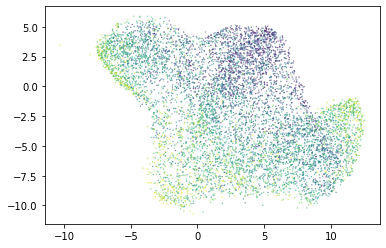

In [80]:
cond = alpha_true > 0
plt.scatter(X[cond,0],X[cond,1],c=target["log_diffusion"][cond],s=.1)

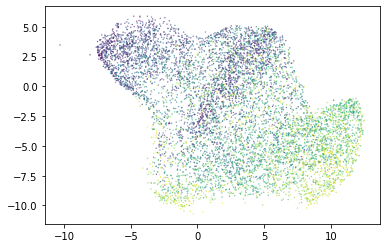

In [81]:
cond = alpha_true > 0
plt.scatter(X[cond,0],X[cond,1],c=alpha_true[cond],s=.1)

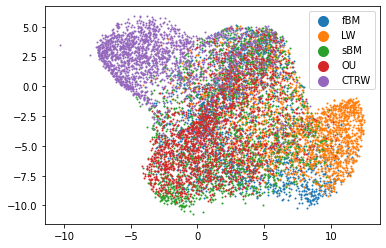

In [82]:
for m in np.unique(true_model):
    plt.scatter(X[true_model == m,0],X[true_model == m,1],s=1,label=ds_params["RW_types"][m])
plt.legend(markerscale=10)

In [39]:
import numpy as np

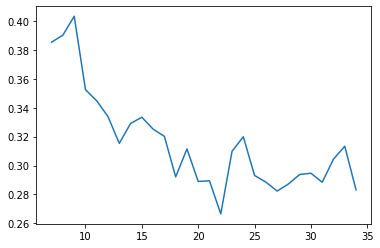

In [70]:
mean_err = [np.mean(np.abs(alpha[(target["length"] == L) & (alpha_true > 0)] - alpha_true[(target["length"] == L) & (alpha_true > 0)])) for L in np.unique(target["length"])]
length = np.unique(target["length"])
plt.plot(length, mean_err)

In [ ]:
ds = dm.ds_test
import numpy as np

In [ ]:
msds = {0:[],1:[],2:[],3:[],4:[],5:[]}

In [ ]:
for data in ds:
    msds[int(data.model[0,0])].append(np.linalg.norm(data.pos,axis=1)**2)

In [ ]:
L = ds_params["length_range"][1] - 20

In [ ]:
msds_time_long = np.zeros((6,L-7))
msds_time_short = np.zeros((6,L-7))
T_thresh = 200
for i in range(6):
    for t in range(7,L):
        msds_time_short[i,t-7] = np.mean([msd[t] for msd in msds[i] if len(msd) >= t+1 and len(msd) < T_thresh])
        msds_time_long[i,t-7] = np.mean([msd[t] for msd in msds[i] if len(msd) >= max(t+1,T_thresh)])

/Users/hverdier/opt/miniconda3/envs/gratin/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hverdier/opt/miniconda3/envs/gratin/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import matplotlib.pyplot as plt

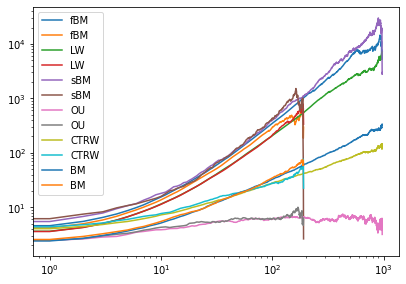

In [ ]:
for i in range(6):
    plt.plot(msds_time_long[i],label=ds_params["RW_types"][i])
    plt.plot(msds_time_short[i],label=ds_params["RW_types"][i])
plt.tight_layout()
plt.legend()
plt.xscale("log")
plt.yscale("log")